# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

## Инструкции

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [4]:
import pandas as pd
from sklearn.model_selection import learning_curve, cross_val_score, GridSearchCV, StratifiedKFold, cross_validate, train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from xgboost import XGBClassifier
from sklearn.linear_model import Lasso
import numpy as np
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
from warnings import filterwarnings
filterwarnings('ignore')

In [5]:
# Удаление столбцов, где пропусков больше 2000. Drop_single - выкидываем признак, если у него 1 уникальное значение
def drop_uninformative(data, thresh=2000, drop_single = False, fill_realna = 'mean', fill_catna = 'no_value'):
    if drop_single:
        data = data[(data.apply(pd.Series.nunique) > 1).index]
    data = data.dropna(axis=1, how='all', thresh=thresh)
    if fill_realna == 'mean':
        try:
            data.loc[:, :'Var190'] = data.loc[:, :'Var190'].fillna(data.mean())
        except KeyError:
            data.loc[:, :'Var189'] = data.loc[:, :'Var189'].fillna(data.mean())
        except Exception:
            data.loc[:, :'Var188'] = data.loc[:, :'Var188'].fillna(data.mean())
    else:
        try:
            data.loc[:, :'Var190'] = data.loc[:, :'Var190'].fillna(fill_realna)
        except KeyError:
            data.loc[:, :'Var189'] = data.loc[:, :'Var189'].fillna(fill_realna)
        except Exception:
            data.loc[:, :'Var188'] = data.loc[:, :'Var188'].fillna(fill_realna)
    data = data.fillna(fill_catna)
    return data

# Объединение значений, чье число меньше n
def unite_labels(column, n):
    val = column.value_counts()
    new_val = (val >= n) * range(1, len(val) + 1)
    return column.map(new_val)
    
# Если в категориальном признаке есть значения, количество которых меньше N - объединим их
def data_transform(data, n):
    try:
        real_data = data.loc[:, :'Var190']
    except KeyError:
        real_data = data.loc[:, :'Var189']
    except Exception:
        real_data = data.loc[:, :'Var188']
    data_to_transform = data.loc[:, list(set(data.columns) - set(real_data.columns))]
    for column in data_to_transform.columns:
        data_to_transform.loc[:, column] = unite_labels(data_to_transform.loc[:, column], n)
    return pd.concat((real_data, data_to_transform), axis=1).apply(pd.to_numeric)

# Функция для label-encoding
def label_encoding(data):
    encoder = preprocessing.LabelEncoder()
    real_data = data.iloc[:, :190]
    data_to_encode = data.iloc[:, 190:]
    for col in data_to_encode.columns:
        encoder.fit(data_to_encode.loc[:, col])
        data_to_encode.loc[:, col] = encoder.transform(data_to_encode.loc[:, col])
    
    return pd.concat((real_data, data_to_encode), axis=1)

In [6]:
# Coef регулирует соотношение классов. 
# Чем он больше, тем меньше нулевого класса будет в выборке, т.е. больше будет перекос к позитивному классу.
def undersampling(data, labels, coef=1):
    class_relation = labels.value_counts()[1] / labels.value_counts()[0]
    if 0 < coef * class_relation < 1:
        pos_indices = labels[labels > 0].index
        neg_indices = labels[labels == 0].index
        undersampled_data = data.iloc[pos_indices, :]
        data_to_append = data.iloc[neg_indices, :].sample(frac=(class_relation * coef))
        undersampled_data = pd.concat((undersampled_data, data_to_append), ignore_index=False, axis=0)
        return undersampled_data, labels[undersampled_data.index]
    else:
        print('coef * class_relation должно лежать в диапазоне от 0 до 1')

In [7]:
train_data = pd.read_csv('orange_small_churn_data.train')
labels = pd.read_csv('orange_small_churn_labels.train', names=['labels'])
labels = labels.applymap(lambda x: 0 if x == -1 else x)
labels = labels.labels

In [8]:
transformed_data = drop_uninformative(train_data, thresh=500)
transformed_data = data_transform(transformed_data, 50)
transformed_data.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var9,Var10,Var11,...,Var216,Var208,Var224,Var197,Var198,Var225,Var218,Var199,Var200,Var217
0,11.003509,0.00497,429.328358,0.148235,249055.515021,3052.0,6.792126,47.487719,381346.56309,8.549254,...,33,1,1,97,0,1,1,0,1,0
1,11.003509,0.00497,429.328358,0.148235,249055.515021,1813.0,7.000000,47.487719,381346.56309,8.549254,...,63,1,1,28,0,2,1,30,0,0
2,11.003509,0.00497,429.328358,0.148235,249055.515021,1953.0,7.000000,47.487719,381346.56309,8.549254,...,0,1,1,3,1,1,2,75,1,0
3,11.003509,0.00497,429.328358,0.148235,249055.515021,1533.0,7.000000,47.487719,381346.56309,8.549254,...,3,1,1,1,0,1,1,166,1,0
4,11.003509,0.00497,429.328358,0.148235,249055.515021,686.0,7.000000,47.487719,381346.56309,8.549254,...,18,1,1,35,0,1,1,0,1,0


In [9]:
def learning_curve_plot(data, labels, estimator, train_sizes = np.linspace(0.1, 1.0, 10)):
    plt.figure(figsize=(20, 6))
    plt.title('Learning curve')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(clf, data, labels, train_sizes=train_sizes,
                                                       groups=labels, scoring='roc_auc', cv=5, shuffle=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std,
                    alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std,
                    alpha=0.1, color='g')
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='cv score')
    
    plt.legend()
    return plt

<module 'matplotlib.pyplot' from 'C:\\Code\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

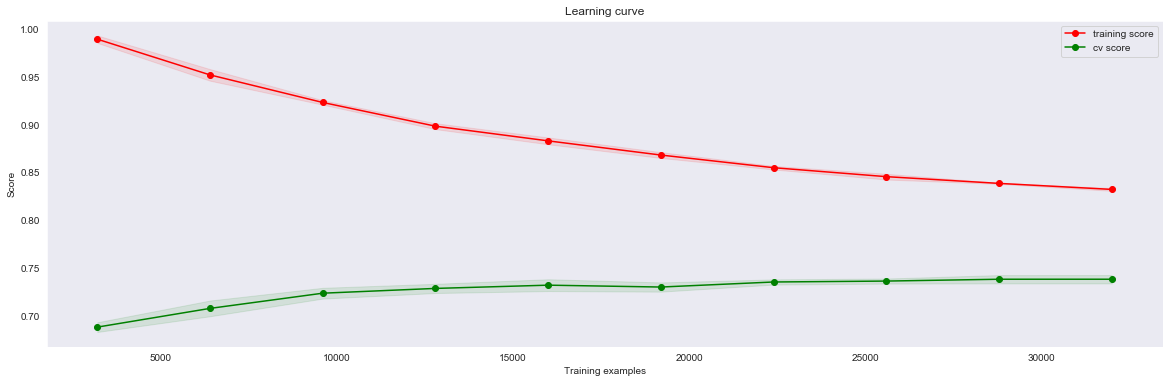

In [10]:
clf = XGBClassifier(max_depth=5, n_estimators=60, scale_pos_weight=1)

learning_curve_plot(transformed_data, labels, clf)

Качество перестает значительно расти примерно на 16000.
На моей машине эта функция выполняется довольно долго, поэтому было бы уместно уменьшить выборку во время экспериментов, а на финальной модели использовать её всю.

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [11]:
neg_class = labels.value_counts()[0] 
pos_class = labels.value_counts()[1] 

weights_options = [
    neg_class / pos_class ,  # Сбалансированный
    neg_class * 1.25/ pos_class,
    neg_class * 1.5 / pos_class,  # дисбаланс в сторону позитивного класса
    neg_class / 1.25 / pos_class,
    neg_class / 1.5 / pos_class  # дисбаланс в сторону нулевого класса
]

for weights in weights_options:
    clf = XGBClassifier(max_depth=5, n_estimators=60, scale_pos_weight=weights)
    print('Значение ROC-AUC на кросс-валидации при соотношении весов {} равно '.format(weights), 
          cross_val_score(clf, transformed_data, labels, scoring='roc_auc', cv=5).mean())

Значение ROC-AUC на кросс-валидации при соотношении весов 12.440860215053764 равно  0.7313596732782672
Значение ROC-AUC на кросс-валидации при соотношении весов 15.551075268817204 равно  0.7315739451205616
Значение ROC-AUC на кросс-валидации при соотношении весов 18.661290322580644 равно  0.7289552136078654
Значение ROC-AUC на кросс-валидации при соотношении весов 9.952688172043011 равно  0.7330262607882401
Значение ROC-AUC на кросс-валидации при соотношении весов 8.293906810035843 равно  0.7353761801242111


Как ни странно, более сильный дисбаланс в сторону нулевого класса дает лучший результат на кросс-валидации.

In [12]:
weights = 1
clf = XGBClassifier(max_depth=5, n_estimators=60, scale_pos_weight=weights)
print('Значение ROC-AUC на кросс-валидации при соотношении весов {} равно '.format(weights), 
          cross_val_score(clf, transformed_data, labels, scoring='roc_auc', cv=5).mean())

Значение ROC-AUC на кросс-валидации при соотношении весов 1 равно  0.7386913289008014


In [13]:
weights = 0.5
clf = XGBClassifier(max_depth=5, n_estimators=60, scale_pos_weight=weights)
print('Значение ROC-AUC на кросс-валидации при соотношении весов {} равно '.format(weights), 
          cross_val_score(clf, transformed_data, labels, scoring='roc_auc', cv=5).mean())

Значение ROC-AUC на кросс-валидации при соотношении весов 0.5 равно  0.7373405840166423


В данном случае неотбалансированный вариант, с весами = 1, выглядит лучше с точки зрения ROC_AUC.

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [14]:
for coef in [0.5, 0.75, 1, 1.25]:
    undersampled_data, undersampled_labels = undersampling(transformed_data, labels, coef=coef)
    print(cross_val_score(clf, undersampled_data, undersampled_labels, scoring='roc_auc', cv=5).mean())

0.7114331775653999
0.7320148306146066
0.7283637601075188
0.7302322060021238


Результат получается немного хуже, чем при использовании всего датасета, но зато намного быстрее. Лучший результат с точки зрения roc_auc получается при сбалансированной по меткам выборки.

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

1) Замена пропусков в числовых средними значениями, в категориальных - наиболее часто повторяющимися. Посмотрим, как меняется ROC-AUC при изменении количества "выкинутых" признаков и объединенных значений.

In [15]:
clf = XGBClassifier(max_depth=3, n_estimators=60, scale_pos_weight=1)
# Выкидываем признак, если он заполнен меньше, чем на thresh
for thresh in [500, 1000, 2000, 5000, 10000]:
        transformed_data = drop_uninformative(train_data, thresh=thresh, drop_single=True, fill_realna='mean', fill_catna='no_value')
        transformed_data = data_transform(transformed_data, 50)
        print('Для thresh = {} - ROC-AUC ='.format(thresh), 
              cross_val_score(clf, transformed_data, labels, scoring='roc_auc', cv=5).mean())

Для thresh = 500 - ROC-AUC = 0.7385937369742457
Для thresh = 1000 - ROC-AUC = 0.7385549051882861
Для thresh = 2000 - ROC-AUC = 0.7383994292268607
Для thresh = 5000 - ROC-AUC = 0.7383994292268607
Для thresh = 10000 - ROC-AUC = 0.7383994292268607


Результат немнго ухудшился с отбросом признаков больше 500, но скорость заметно выросла.
А теперь сравним эти результаты с тем, чтобы заменить числовые признаки на 0, и без выкидыванием колонок с единственным значением

In [16]:
for drop_single in [True, False]:
    transformed_data = drop_uninformative(train_data, thresh=10000, drop_single=drop_single, fill_realna='mean', fill_catna='no_value')
    transformed_data = data_transform(transformed_data, 50)
    print(cross_val_score(clf, transformed_data, labels, scoring='roc_auc', cv=5).mean())
    
transformed_data = drop_uninformative(train_data, thresh=10000, drop_single=True, fill_realna=0, fill_catna='no_value')
transformed_data = data_transform(transformed_data, 50)
print(cross_val_score(clf, transformed_data, labels, scoring='roc_auc', cv=5).mean())

0.7383994292268607
0.7383994292268607
0.7388911114080894


4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

Ранее уже мы работали с label-encoder'ом, теперь рассмотрим dummy кодирование и сравним результат с предыдущими.

In [17]:
# Для ускорения выкинем 10000
transformed_data = drop_uninformative(train_data, thresh=10000, drop_single=False, fill_realna='mean', fill_catna='no_value')
# Также, как и раньше, объединим категориальные, где мало значений
transformed_data.loc[:, 'Var189':] = transformed_data.loc[:, 'Var189':].apply(lambda x: unite_labels(x, 50))
cat_columns = transformed_data.loc[:, 'Var189':].columns
transformed_data = pd.get_dummies(transformed_data, drop_first=True, columns=cat_columns)
print(cross_val_score(clf, transformed_data, labels, scoring='roc_auc', cv=5).mean())

0.7338385177955005


Качество упало на полпроцента. Попробуем еще нормализовать числовые признаки.

In [18]:
scaler = StandardScaler()
# Для ускорения выкинем 10000
transformed_data = drop_uninformative(train_data, thresh=10000, drop_single=False, fill_realna='mean', fill_catna='no_value')
# Также, как и раньше, объединим категориальные, где мало значений
transformed_data.loc[:, 'Var189':] = transformed_data.loc[:, 'Var189':].apply(lambda x: unite_labels(x, 50))
# Нормализуем числовые признаки
transformed_data.loc[:, :'Var181'] = pd.DataFrame(scaler.fit_transform(transformed_data.loc[:, :'Var181']),
                                                 columns = transformed_data.loc[:, :'Var181'].columns)
cat_columns = transformed_data.loc[:, 'Var189':].columns
transformed_data = pd.get_dummies(transformed_data, drop_first=True, columns=cat_columns)
print(cross_val_score(clf, transformed_data, labels, scoring='roc_auc', cv=5).mean())

0.7338385177955005


Для этого датасета это бесполезно. Лучше всего использовать label-encoder, так как он работает на порядок быстрее и дает лучший результат.

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

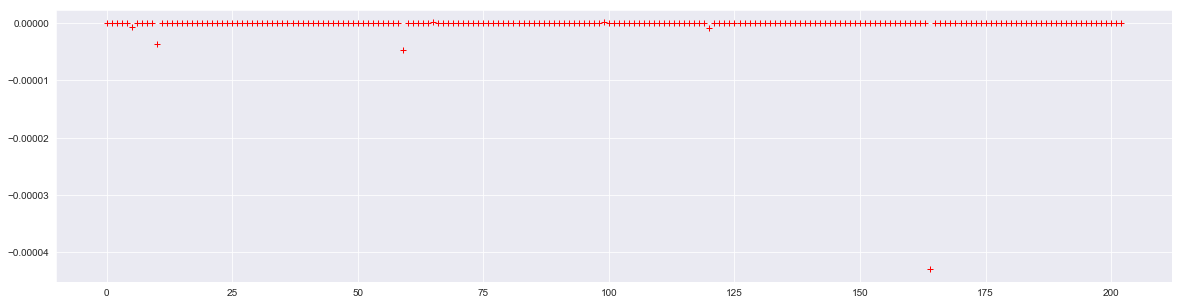

In [19]:
transformed_data = drop_uninformative(train_data, thresh=500, drop_single=False, fill_realna='mean', fill_catna='no_value')
transformed_data = data_transform(transformed_data, 50)
lasso = Lasso()
lasso.fit(transformed_data, labels)
plt.figure(figsize=(20, 5))
plt.plot(lasso.coef_, 'r+')

In [20]:
cols_selected = transformed_data.columns[lasso.coef_ != 0]
selected_data = transformed_data[cols_selected]
print(cross_val_score(clf, selected_data, labels, scoring='roc_auc', cv=5).mean())

0.6488308105575176


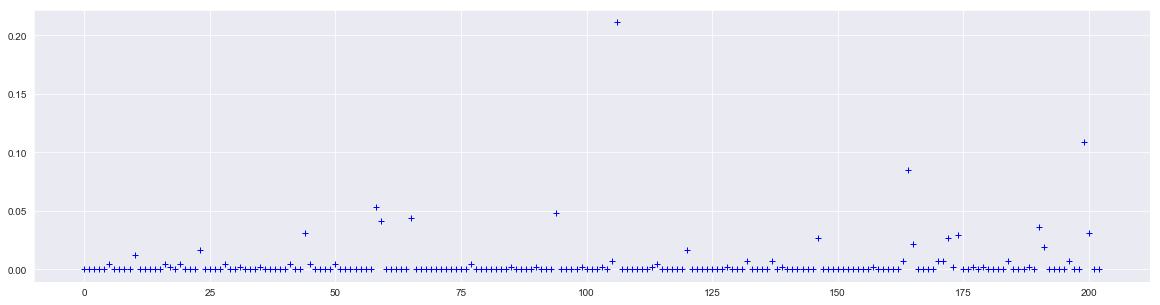

In [21]:
clf.fit(transformed_data, labels)
plt.figure(figsize=(20, 5))
plt.plot(clf.feature_importances_, 'b+')

In [22]:
cols_selected = transformed_data.columns[clf.feature_importances_ > 0.005]
selected_data = transformed_data[cols_selected]
print(cross_val_score(clf, selected_data, labels, scoring='roc_auc', cv=5).mean())

0.740184707544853


Как и ожидалось, XGB отбирает признаки лучше, чем линейный лассо. Хотя бы потому, наверное, что мы не добавили квадраты признаков, чтобы линейная справилась. Кроме того, результат немного улучшился с отбором признаков.

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

In [23]:
est = XGBClassifier()

params = {'max_depth': [4, 5, 6],
         'n_estimators': [40, 50, 60, 70],
         'learning_rate': [0.05, 0.1]}

xgrid = GridSearchCV(est, param_grid=params, scoring='roc_auc', iid=False, cv=3, return_train_score=False)
xgrid.fit(selected_data, labels)
print(xgrid.best_params_)

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 70}


In [24]:
clf = XGBClassifier(max_depth=3, n_estimators=60)
print(cross_val_score(clf, selected_data, labels, scoring='roc_auc', cv=5).mean())

0.740184707544853


7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

In [27]:
clf.fit(selected_data, labels)
# Топ-20 признаков по влиянию на модель
sorted(list(zip(transformed_data.columns, clf.feature_importances_)), key=lambda x: x[1], reverse=True)[:20]

[('Var10', 0.21065375),
 ('Var29', 0.118644066),
 ('Var18', 0.08232445),
 ('Var4', 0.07263923),
 ('Var7', 0.055690072),
 ('Var6', 0.04842615),
 ('Var5', 0.041162226),
 ('Var23', 0.03874092),
 ('Var24', 0.036319613),
 ('Var26', 0.031476997),
 ('Var16', 0.02905569),
 ('Var2', 0.026634382),
 ('Var3', 0.026634382),
 ('Var30', 0.026634382),
 ('Var1', 0.021791767),
 ('Var19', 0.021791767),
 ('Var11', 0.01937046),
 ('Var27', 0.01937046),
 ('Var28', 0.01937046),
 ('Var13', 0.014527845)]

In [28]:
# Топ-20 признаков не влияющих на модель
sorted(list(zip(transformed_data.columns, clf.feature_importances_)), key=lambda x: x[1], reverse=False)[:20]

[('Var17', 0.004842615),
 ('Var21', 0.004842615),
 ('Var9', 0.0072639226),
 ('Var14', 0.0072639226),
 ('Var22', 0.0072639226),
 ('Var25', 0.0072639226),
 ('Var13', 0.014527845),
 ('Var11', 0.01937046),
 ('Var27', 0.01937046),
 ('Var28', 0.01937046),
 ('Var1', 0.021791767),
 ('Var19', 0.021791767),
 ('Var2', 0.026634382),
 ('Var3', 0.026634382),
 ('Var30', 0.026634382),
 ('Var16', 0.02905569),
 ('Var26', 0.031476997),
 ('Var24', 0.036319613),
 ('Var23', 0.03874092),
 ('Var5', 0.041162226)]

Похоже, что среди топа значимых категорийных признаков немного больше, чем числовых, а среди самых бесполезных признаков только числовые

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

In [29]:
# Функция для нахождения уверенности
def difference(y_pred, y_true):
    if y_true == 0:
        return y_pred[0]
    else:
        return y_pred[1]

In [30]:
# thresh - степень уверенности в верной метке, ниже котороый мы считаем ошибку классификации большой
def find_wrong_indices(data, labels, estimator, thresh=0.3, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True)
    data['wrong_ind'] = np.zeros(data.shape[0])
    for train_index, test_index in skf.split(data, labels):
        estimator.fit(data.iloc(axis=0)[train_index, :], labels.iloc(axis=0)[train_index])
        pred_proba = estimator.predict_proba(data.iloc(axis=0)[test_index, :])
        y_true = labels.iloc(axis=0)[test_index]
        wrong_indices = map(difference, pred_proba, y_true)
        wrong_indices = pd.Series(list(wrong_indices), index=y_true.index)
        data.loc[wrong_indices[wrong_indices < thresh].index, ['wrong_ind']] = 1
        
    return data

In [31]:
selected_data = find_wrong_indices(selected_data, labels, clf, thresh=0.2, cv=5)

In [32]:
selected_data.head()

,Var13,Var28,Var57,Var73,Var74,Var81,Var113,Var125,Var126,Var140,...,Var222,Var210,Var205,Var206,Var192,Var226,Var197,Var218,Var199,wrong_ind
0,1244.979978,200.00,2.907926,34,101.329724,14599.92,-1209960.0,28051.417407,4.000000,1379.299072,...,0,1,2,1,72,6,97,1,0,0.0
1,636.000000,166.56,5.870327,128,0.000000,67529.09,417932.0,24912.000000,40.000000,205.000000,...,0,1,1,5,9,10,28,1,30,0.0
2,448.000000,311.76,5.981628,166,245.000000,85266.00,-124655.2,7218.000000,36.000000,400.000000,...,1,1,1,6,27,1,3,2,75,0.0
3,4.000000,220.08,5.108097,30,0.000000,74107.20,378473.6,693.000000,-0.569916,5.000000,...,0,1,1,1,129,10,1,1,166,1.0
4,0.000000,278.00,0.650716,32,0.000000,171072.90,142602.4,468.000000,-28.000000,225.000000,...,0,1,3,2,23,3,35,1,0,0.0


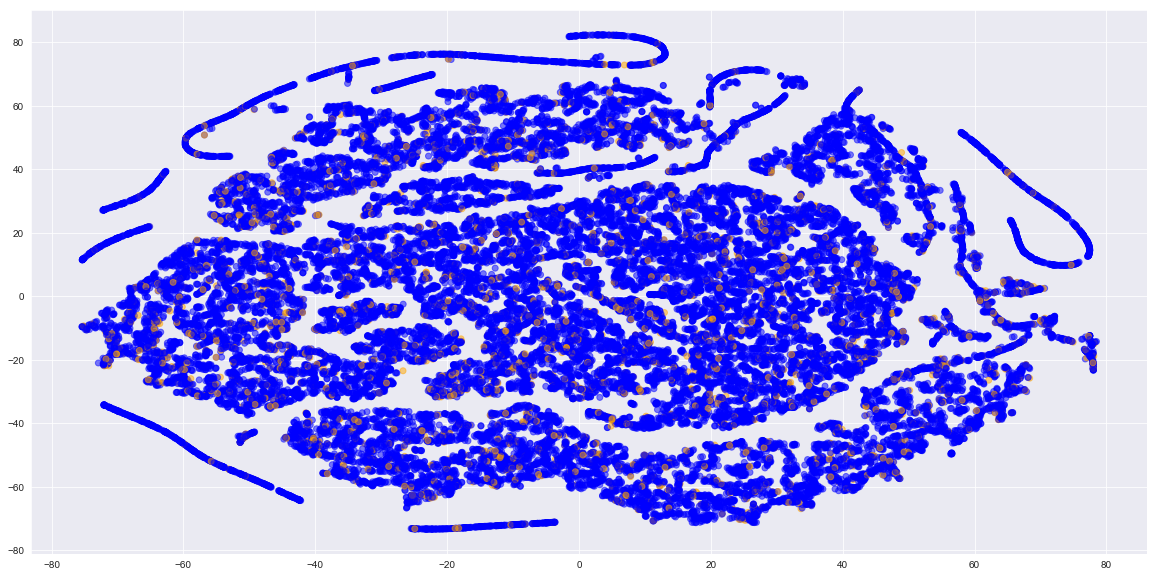

In [273]:
tsne = TSNE()
tsne_representation = tsne.fit_transform(selected_data.drop(['wrong_ind'], axis=1))
plt.figure(figsize=(20, 10))
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], c=selected_data['wrong_ind'].map({0: 'blue', 1: 'orange'}), 
           alpha=0.5)

Судя по TSNE-отображению, ничего заметно общего найти не удаётся. Возможно, взяли слишком большой порог, и самые-самые ошибочные как-то бы группировались.

In [298]:
clf.fit(selected_data.iloc[:, :-1], labels)
important_features = sorted(list(zip(selected_data.iloc[:, :-1].columns, clf.feature_importances_)), key=lambda x: x[1], reverse=False)[:10]
important_features = [i[0] for i in important_features[:10]]

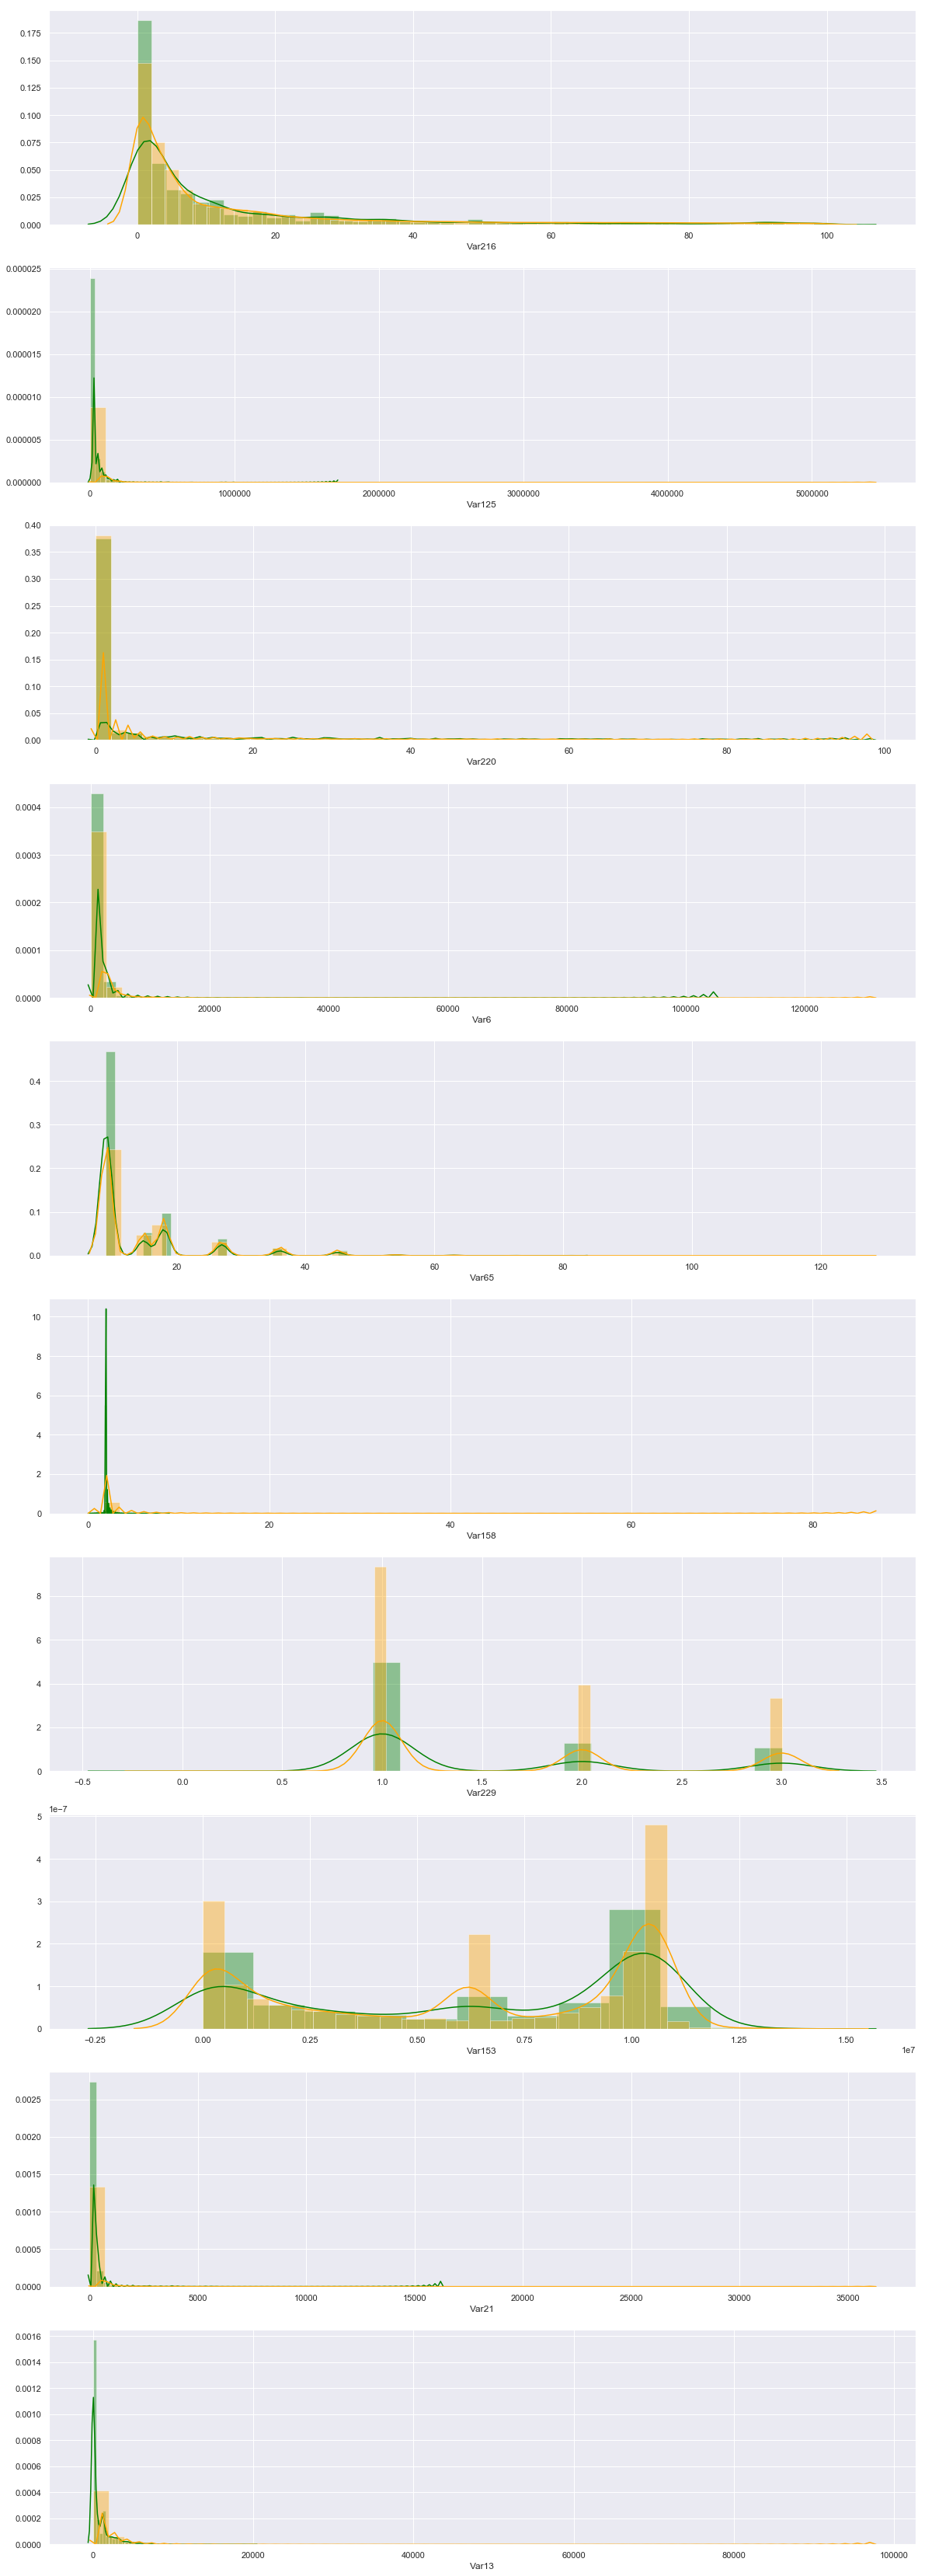

In [299]:
fig, axs = plt.subplots(10, figsize = (20,60))
sns.set(color_codes=True)
for ax, column in zip(axs,  important_features):
    sns.distplot(selected_data[column][labels == 1], ax = ax, color = "green", label = str(column)+" label = 1")
    sns.distplot(selected_data[column][labels == 0], ax = ax, color = "orange", label = str(column)+" label = 0")

Худшие из отобранных признаков имеют выбросы, не вписывающиеся в стандартный интервал. Скорее всего это и послужило одной из причин их негодности.

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

Для построения я выбрал классификатор XGBoost, он показал на прошлой неделе лучший результат. По итогам оптимизации были выбраны следующие параметры:
learning_rate=0.1, 
max_depth=4, 
n_estimators=60
Классификатор на кросс-валидации показал ROC-AUC = 0.74

С данными лучшими оказались следующие преобразования: в категориальных столбцах объединение таких категорий, если их меньше 50 и использование Label Encoder. С числовыми - замена пропусков средним значением. Также с числовыми выкинули столбцы с большим количеством пропусков, но это, я думаю, не важно, так как дальше с помощью XGB отобрали самые важные признаки.

In [302]:
clf = XGBClassifier(learning_rate=0.1, max_depth=4, n_estimators=60)
clf.fit(selected_data, labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=60,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

Можно избавиться от выбросов и более точно попытаться подобрать параметры алгоритма (что вычислительно сложно, особенно для моей слабой машины)

#### Вычисления для экономического расчета:

In [306]:
X_train, X_test, y_train, y_test = train_test_split(selected_data, labels, test_size=0.25, stratify=labels)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)

print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9256
           1       0.99      0.91      0.95       744

   micro avg       0.99      0.99      0.99     10000
   macro avg       0.99      0.95      0.97     10000
weighted avg       0.99      0.99      0.99     10000



In [327]:
def classif_report(data, labels, estimator, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True)
    result = {0: {'precision': 0, 'recall': 0}, 1: {'precision': 0, 'recall': 0}}
    for train_index, test_index in skf.split(data, labels):
        estimator.fit(data.iloc(axis=0)[train_index, :], labels.iloc(axis=0)[train_index])
        pred = estimator.predict(data.iloc(axis=0)[test_index, :])
        y_true = labels.iloc(axis=0)[test_index]
        report_dict = metrics.classification_report(y_true, pred, output_dict=True)
        for i in [0, 1]:
            for char in ['precision', 'recall']:
                result[i][char] += report_dict[str(i)][char]
        
    for i in [0, 1]:
        for char in ['precision', 'recall']:
            result[i][char] /= cv
            
    return result

In [328]:
report = classif_report(selected_data, labels, clf, cv=5)
print(report)

{0: {'precision': 0.9930741365275011, 'recall': 0.9991357081651213}, 1: {'precision': 0.9883673973804822, 'recall': 0.9133060741074953}}
